<h1><center>Solving Linear Equations with Quantum Circuits</center></h1>

<h2><center>Ax = b</center></h2>
<h4><center> Attempt to replicate the following paper </center></h4>

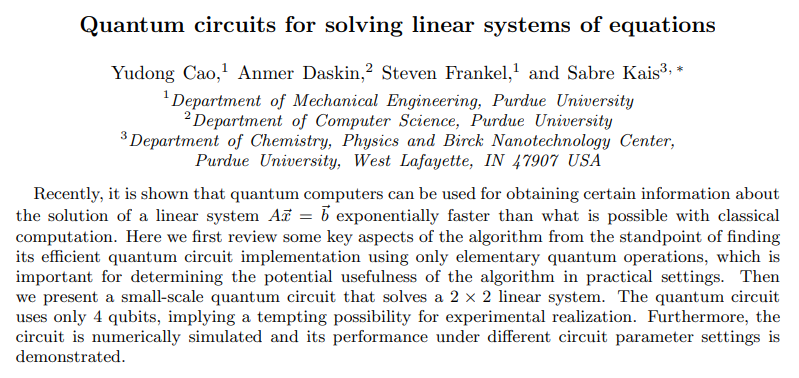

<h3><center>Algorithm for a simpler 2 x 2 example</center></h3>

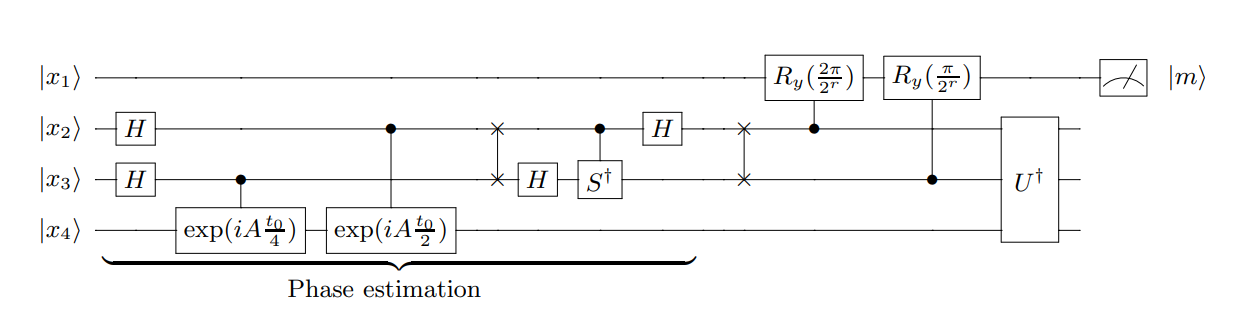

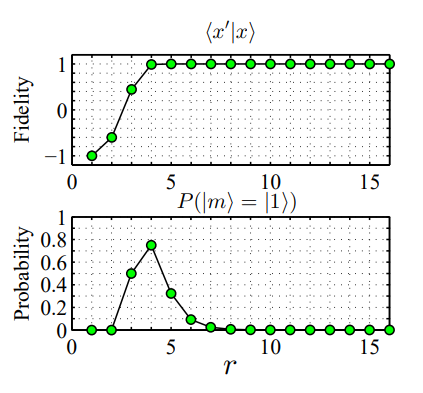

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$
The Final state looks like: 
$$ \ket{\psi} = \sum_{j=1}^N \beta_j \left( \sqrt{1-\frac{C^2}{\lambda_j^2}} \ket{0} + \frac{C}{\lambda_j} \ket{1} \right) \ket{00} \ket{u_j} $$

In [213]:
#Solving a linear system of equation for 2 dimensional equantion of the form Ax = b

### code specific initialization (importing libraries)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import *
import scipy

# importing Qiskit
from qiskit import IBMQ, BasicAer
#from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

from qiskit.quantum_info.synthesis import euler_angles_1q 
from cmath import exp

### problem specific parameters

# matrix representation of linear equation
A = 0.5*np.array([[3,1],[1,3]])
t0 = 2*pi #time paramter appearing in the unitary
r = 4

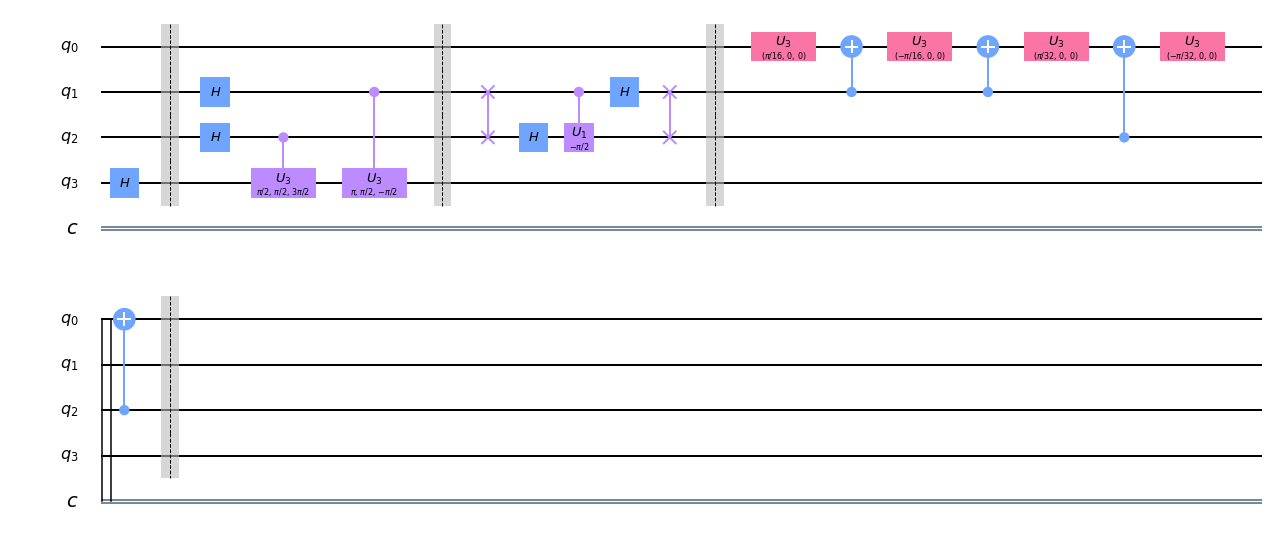

In [214]:
q = QuantumRegister(4, 'q')
c = ClassicalRegister(1, 'c')

qpe = QuantumCircuit(q,c)
qpe.h(q[3])
qpe.barrier()

qpe.h(q[1])
qpe.h(q[2])

# 1st unitary corresponding to A
UA = scipy.linalg.expm(complex(0,1)*A*t0/4)
[theta, phi, lmda] = euler_angles_1q(UA)
qpe.cu3(theta, phi, lmda,q[2],q[3])

# 2nd unitary corresponding to A
UA = scipy.linalg.expm(complex(0,1)*A*2*t0/4)
[theta, phi, lmda] = euler_angles_1q(UA)
qpe.cu3(theta, phi, lmda,q[1],q[3])
qpe.barrier()

# quantum fourier transform
qpe.swap(q[1],q[2])
qpe.h(q[2])
qpe.cu1(-pi/2,q[1],q[2])
qpe.h(q[1])
qpe.swap(q[1],q[2])

qpe.barrier()

#controlled rotations gate
qpe.cry(2*pi/(2**r),q[1],q[0])
qpe.cry(pi/(2**r),q[2],q[0])

qpe.barrier()

qpe.draw(output="mpl")

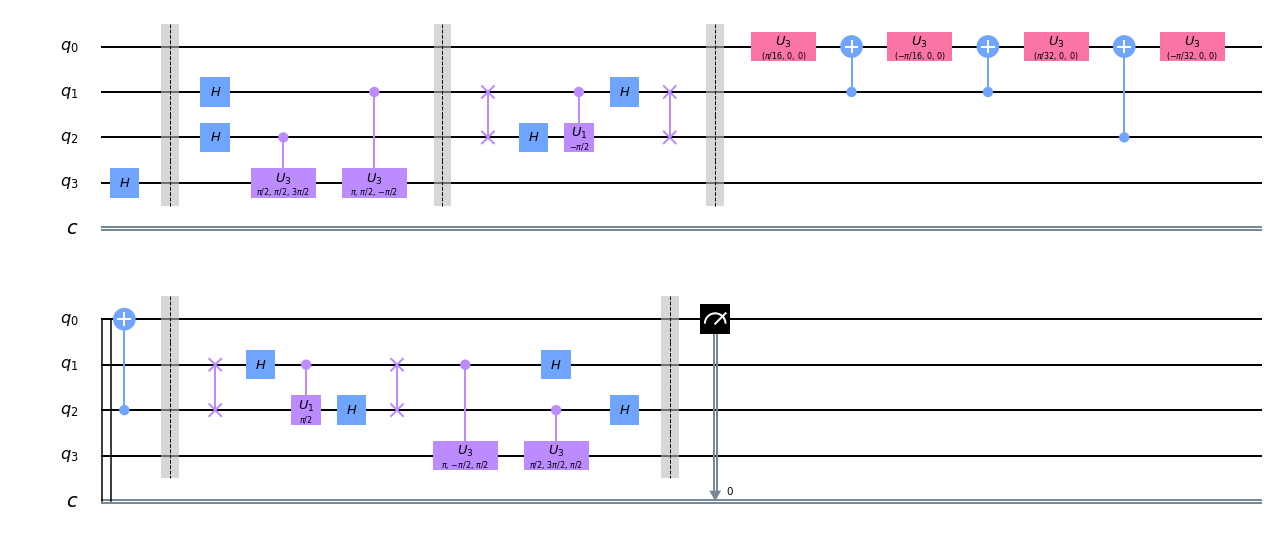

In [215]:
###############################################################

### uncomputation
# reversing fourier transform
qpe.swap(q[1],q[2])
qpe.h(q[1])
qpe.cu1(pi/2,q[1],q[2])
qpe.h(q[2])
qpe.swap(q[1],q[2])

# reversing 2nd unitary corresponding to A
UA = scipy.linalg.expm(complex(0,-1)*A*2*t0/4)
[theta, phi, lmda] = euler_angles_1q(UA)
qpe.cu3(theta, phi, lmda,q[1],q[3])

# reversing 1st unitary corresponding to A
UA = scipy.linalg.expm(complex(0,-1)*A*t0/4)
[theta, phi, lmda] = euler_angles_1q(UA)
qpe.cu3(theta, phi, lmda,q[2],q[3])

qpe.h(q[1])
qpe.h(q[2])

qpe.barrier()
qpe.draw(output="mpl")

qpe.measure(q[0], c[0])
qpe.draw(output="mpl")

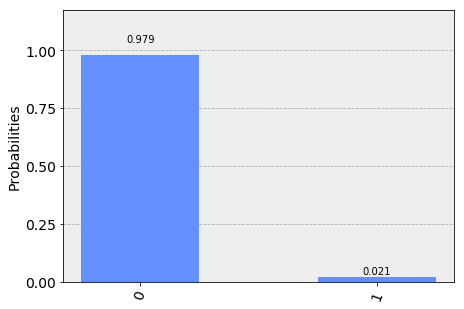

In [216]:
circuit = qpe
simulator = BasicAer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator, shots = 2048).result()
counts = result.get_counts()
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)